# Spherical Stratified Atmosphere
This page explains how to transform the stratified atmosphere test problem (originally given in cylindrical and rectangular coordinates) into a spherical setup. The following test problems are good references for spherical geometry:
- HD/Disk_Planet
    - Configs 3,4,5
- HD/Sedov
    - Config 3
- HD/Sod

# Pluto INI
## Grid Setup
We will use Disk_Planet as our primary reference for configuring the grid. Page 18 of the PLUTO user guide tells us that the solver's convention for spherical coordinates is X1 = radius, X2 = altitude, and X3 = azimuth. Thus, Disk_Planet's grid analyzes a 3D slice of the atmosphere which varies between a radius of 0.4 and 2.5, goes completely around the sphere in terms of azimuth, but which is highly confined in terms of elevation.

We will increase the elevation so that it spans a range of $\pm 80^\circ$, so that we cover the sphere reasonably well while avoiding the computational difficulties near the poles. We will now look at how this is done.

The following are the lower bound, upper bound, and resolution for the elevation coordinate, provided for Disk_Planet.

$$
X2_l = 1.448623279 \\
X2_u = 1.570796327 \\
X2_{res} = 16
$$

We will assume that 16 cells is a good number for a grid of this size. In this case, the width of a single cell is: 

$$
W = \frac{X2_u - X2_l}{X2_{res}} = 7.64 \times 10^{-3}
$$

Given this cell width, we will need $N$ cells to cover a elevation range $\Delta L$ (in degrees), where $N$ is defined below.

\begin{equation}
N = \frac{\pi}{180} \frac{\Delta L}{W}
\end{equation}

For $\Delta$L = 160$^\circ$ (i.e. 10 degrees away from the poles), $N$ = 366 and our bounding coordinates are $\pi/2 \pm\Delta L \frac{\pi}{180} = \pi/2 \pm1.396263402$ (we add $\pi/2$ because the angle is relative to the cartesian z-axis instead of the xy-plane).

Since we do not require fine computation to validate this setup, let us decrease the resolution along the radial, latitudinal, and longitudinal coordinate by 5, 10, and 10, respectively. Additionally, let us use the same azimuthal grid as Disk_Planet. For the radial grid, we will make a uniform grid from 0.01 to 1 with 20 points, and another uniform grid from 1 to 1.2 with 10 points. Our grid is now as follows:

```
X1-grid    2    0.01         20 u 1.0            10 u 1.2
X2-grid    1    0.1745329248 37 u 2.967059729
X3-grid    1    0.0          40 u 6.283185307
```

This will reduce the number of points from about 18 million to under $40,000$, which will give us a faster turnaround time (< 5 min).

## Time Setup
I changed CFL to 0.25 because I assumed that since this is what Disk_Planet is using, it will result in better solutions for spherical geometries. I also set tstop to 10.0 (1 did not seem like enough and 50 seemed like too much since the size our grid now contains so many cells).

## Solver Setup
I changed the solver to hllc for the same reason I set CFL to 0.25.

## Boundary Conditions
Next, we need to set up the boundary conditions. To stick with the physical situation of the stratified atmosphere, we will use the same boundary conditions for the radial coordinate in our spherical geometry that were using for the radial coordinate in the cylindrical geometry (after all, gravity was indeed given as a piecewise function partitioned based on the spherical radius in the original cylindrical setup). We will also need to modify the implementation for the body force functions as per page 56 of the PLUTO user guide, so that we have the correct physics for the spherical geometry case (more on this later).

For the azimuthal boundary condition, we will stick with periodic for the start and end, which is what Disk_Planet used.
For the latitudinal boundary condition, we will go with reflective for the start and end. We could also try outflow for latitudinal and see what happens. My understanding is reflective will cause the fluid to “bounce back” when it reaches the end of the computational domain, and outflow will cause any flow leaving the computational domain to re-enter at another inlet.

# Definitions.h
The key parameters are as follows:
```C
#define  PHYSICS                 HD
#define  DIMENSIONS              3
#define  COMPONENTS              3
#define  GEOMETRY                SPHERICAL
#define  BODY_FORCE              VECTOR
#define  COOLING                 NO
#define  RECONSTRUCTION          LINEAR
#define  TIME_STEPPING           RK2
#define  DIMENSIONAL_SPLITTING   NO
#define  NTRACER                 0
#define  USER_DEF_PARAMETERS     1
```
Note that we now have 3 dimensions and components. This allows our grid to vary in all 3 of X1, X2, and X3.

# Init.c
Because the latitudinal (X2) boundary condition is no longer user-defined, we will modify ```UserDefBoundary``` so that the user-defined boundary used before is not compiled in the spherical setup.

```C
void UserDefBoundary (const Data *d, RBox *box, int side, Grid *grid) 
{
...
    #if GEOMETRY != SPHERICAL
    X2_END_LOOP(k,j,i){
      #if GEOMETRY == CARTESIAN
       rs = sqrt(x1[i]*x1[i] + x2[j]*x2[j] + x3[k]*x3[k]);
      #elif GEOMETRY == CYLINDRICAL
       rs = sqrt(x1[i]*x1[i] + x2[j]*x2[j]);
      #elif GEOMETRY == SPHERICAL
       rs = sqrt(x1[i]*x1[i]);
      #endif
      d->Vc[RHO][k][j][i] = exp(g_inputParam[ALPHA]*(1.0/rs - 1.0));
      EXPAND(d->Vc[VX1][k][j][i] = 0.0;   ,
             d->Vc[VX2][k][j][i] = 0.0;   ,
             d->Vc[VX3][k][j][i] = 0.0;)
      d->Vc[PRS][k][j][i] = exp(g_inputParam[ALPHA]*(1.0/rs - 1.0))/g_inputParam[ALPHA];
    }
    #endif
...
}
```



We will also modify ```BodyForceVector``` so that we compute the spherical radius in the spherical case:

```C
void BodyForceVector(double *v, double *g, double x1, double x2, double x3)
{
  double gs, rs;
  double acf, bcf, ccf;

  acf = -3.0;
  bcf =  2.0;
  ccf =  0.0;
  #if GEOMETRY == CARTESIAN
   rs = sqrt(x1*x1 + x2*x2 + x3*x3);
  #elif GEOMETRY == CYLINDRICAL
   rs = sqrt(x1*x1 + x2*x2);
  #elif GEOMETRY == SPHERICAL // <--- Added this
   rs = sqrt(x1*x1);          // <--- Added this
  #endif

  if (rs > 1.0) gs = -1.0/rs/rs;
  else          gs = rs*(acf + rs*(bcf + rs*ccf));

  #if GEOMETRY == CARTESIAN
   g[IDIR] = gs*x1/rs;
   g[JDIR] = gs*x2/rs;
   g[KDIR] = gs*x3/rs;
  #elif GEOMETRY == CYLINDRICAL
   g[IDIR] = gs*x1/rs;
   g[JDIR] = gs*x2/rs;
   g[KDIR] = 0.0;
  #elif GEOMETRY == SPHERICAL
   g[IDIR] = gs;
   g[JDIR] = 0.0;
   g[KDIR] = 0.0;
  #endif
}
```

Finally, we update ```BodyForcePotential``` for the same reason as the last time.

```C
double BodyForcePotential(double x1, double x2, double x3)
{
  double rs, phi;
  double acf, bcf, ccf, C;

  acf = -3.0;
  bcf =  2.0;
  ccf =  0.0;

  #if GEOMETRY == CARTESIAN
   rs = sqrt(x1*x1 + x2*x2 + x3*x3);
  #elif GEOMETRY == CYLINDRICAL
   rs = sqrt(x1*x1 + x2*x2);
  #elif GEOMETRY == SPHERICAL // <--- Added this
   rs = sqrt(x1*x1);          // <--- Added this
  #endif

  C = (0.5*acf + bcf/3.0 + ccf*0.25);  /* integration constant to make phi continuous */
  if (rs > 1.0) phi = -1.0/rs;
  else          phi = -rs*rs*(0.5*acf + rs*(bcf/3.0 + rs*ccf*0.25)) + C - 1.0;

  return phi;
}
```

# Analysis of Results

In [1]:
%matplotlib inline

import os
import sys
import numpy as np

import matplotlib
#matplotlib.use('agg')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pyPLUTO as pp

from __future__ import print_function

## Loading Data
Make sure ```path_to_script```, below, is set to the location where this script is running

In [12]:
path_to_script = os.path.join(os.environ['PLUTO_DIR'], 'Work\\')
w_dir = os.path.join(path_to_script, "data")
print("Loading data from", w_dir)

data_dirs = [directory for directory in os.listdir(os.path.join(w_dir)) if "." not in directory]
print("Found data directories: ")
i = 0
for dir in data_dirs:
    print("\t{0}: {1}".format(i, dir))
    i = i + 1

Loading data from D:\PLUTO\Work\data
Found data directories: 
	0: disk_planet_no_rotation
	1: disk_planet_rotation
	2: res_20u10u_36_40
	3: res_20u10u_36_40_alpha31p3
	4: res_20u10u_36_40_alpha3p13
	5: res_26_37_40
	6: res_26_74_80
	7: rotating
	8: rotating_ic
	9: rotating_ic_3d
	10: rotating_ic_6d
	11: userdeflength


Next, we may have a choice between different data sets to load. These have been enumerated above. To change the data set, change the value of `set_idx`, below to one of the other indices.

In [13]:
set_idx = 9
wdir = os.path.join(w_dir, data_dirs[set_idx] + os.sep)
print("Using working directory", wdir)

Using working directory D:\PLUTO\Work\data\rotating_ic_3d\


Next, we use pyPLUTO to load the data in ```wdir``` into a ```pload``` object. ```dh[n]``` is the data handle for data.```n```.dbl.

In [14]:
n_frames = len([file for file in os.listdir(wdir) if "data" in file and ".dbl" in file])
dh = list() # List of data handles
for i in range(n_frames):
    d = pp.pload(i, w_dir = wdir)
    dh.append(d)

Reading Data file : D:\PLUTO\Work\data\rotating_ic_3d\data.0000.dbl
Reading Data file : D:\PLUTO\Work\data\rotating_ic_3d\data.0001.dbl
Reading Data file : D:\PLUTO\Work\data\rotating_ic_3d\data.0002.dbl
Reading Data file : D:\PLUTO\Work\data\rotating_ic_3d\data.0003.dbl
Reading Data file : D:\PLUTO\Work\data\rotating_ic_3d\data.0004.dbl
Reading Data file : D:\PLUTO\Work\data\rotating_ic_3d\data.0005.dbl
Reading Data file : D:\PLUTO\Work\data\rotating_ic_3d\data.0006.dbl
Reading Data file : D:\PLUTO\Work\data\rotating_ic_3d\data.0007.dbl
Reading Data file : D:\PLUTO\Work\data\rotating_ic_3d\data.0008.dbl
Reading Data file : D:\PLUTO\Work\data\rotating_ic_3d\data.0009.dbl
Reading Data file : D:\PLUTO\Work\data\rotating_ic_3d\data.0010.dbl
Reading Data file : D:\PLUTO\Work\data\rotating_ic_3d\data.0011.dbl
Reading Data file : D:\PLUTO\Work\data\rotating_ic_3d\data.0012.dbl


## 2D Plots
We now define a function to help us with plotting, and also perform some one-time plot configurations.

In [15]:
# TODO(Tyler): instead of simply passing in True or False, we should be able to specify
# the desired elevation angle, or azimuthal angle and then choose the closest value
# that we have on the grid
def plot_density_mesh(data, const_elevation=False, const_azimuth=False, log=False, first_only=False):
    '''
    Plots the density on a radius vs elevation plane, or radius vs azimuth
    plane.
    
    Parameters
    ----------
    data : list of pyPLUTO.pload
        List of data frames
    const_elevation : bool
        If True, plots the density as a function of radius and elevation
        Exclusive to const_azimuth
    const_azimuth : double
        If True, plots the density as a function of radius and azimuth
        Exclusive to const_elevation
    log : bool
        (Optional) Plots the logarithm of the density (base 10)
    first_only : bool
        (Optional) Causes only the first frame to be plotted
    '''
    
    if const_elevation == False and const_azimuth == False:
        const_elevation = True
    
    # Sanity check on inputs
    assert(const_elevation != True or const_azimuth != True), "EITHER the azimuth or elevation may be specified, not both"
    
    nframes = 1 if first_only else len(data)
    nrows   = 1 if first_only else np.round(np.sqrt(nframes))
    ncols   = 1 if first_only else np.round((nframes - nrows) / 2)
    for idx in range(nframes):
        if const_azimuth:
            annotations = ['Log10 Density (time: ' + str(data[idx].SimTime) + ')', 'X1 (radius)', 'X2 (elevation)']
            coord2 = (180 / np.pi) * (data[idx].x2 - np.mean(data[idx].x2))
            qty =  data[idx].rho[:,:,0].T
        else: # elif const_elevation:
            annotations = ['Log10 Density (time: ' + str(dh[idx].SimTime) + ')', 'X1 (radius)', 'X3 (azimuth)']
            coord2 = (180 / np.pi) * data[idx].x3
            qty = data[idx].rho[:,0,:].T
        
        if log:
            qty = np.log10(qty)
        
        plt.subplot(nrows, ncols, idx + 1)
        plt.pcolormesh(data[idx].x1, coord2, qty, vmin=np.floor(np.min(qty)), vmax=np.ceil(np.max(qty)))
        plt.colorbar()
        plt.title(annotations[0])
        plt.xlabel(annotations[1])
        plt.ylabel(annotations[2])


def save_plt(fname, w_dir=wdir):
    '''
    Saves plots to the working directory
    
    Parameters
    ----------
    fname : str
        The name to be given to the image file
    wdir : str
        (Optional) The location where the file is to be saved
    '''
    plt.savefig(os.path.join(w_dir, fname) + '.png')


# Inches
width = 20
height = 15

# One-time plot configuration
plt.rcParams['figure.figsize'] = [width, height]
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)

We now fix the azimuth, and plot how the density varies with radius and elevation. The code below will either plot this relationship for only the first time snapshot, or for all time snapshots depending on whether `only_plot_first_frame`, below, is `True` or `False`.

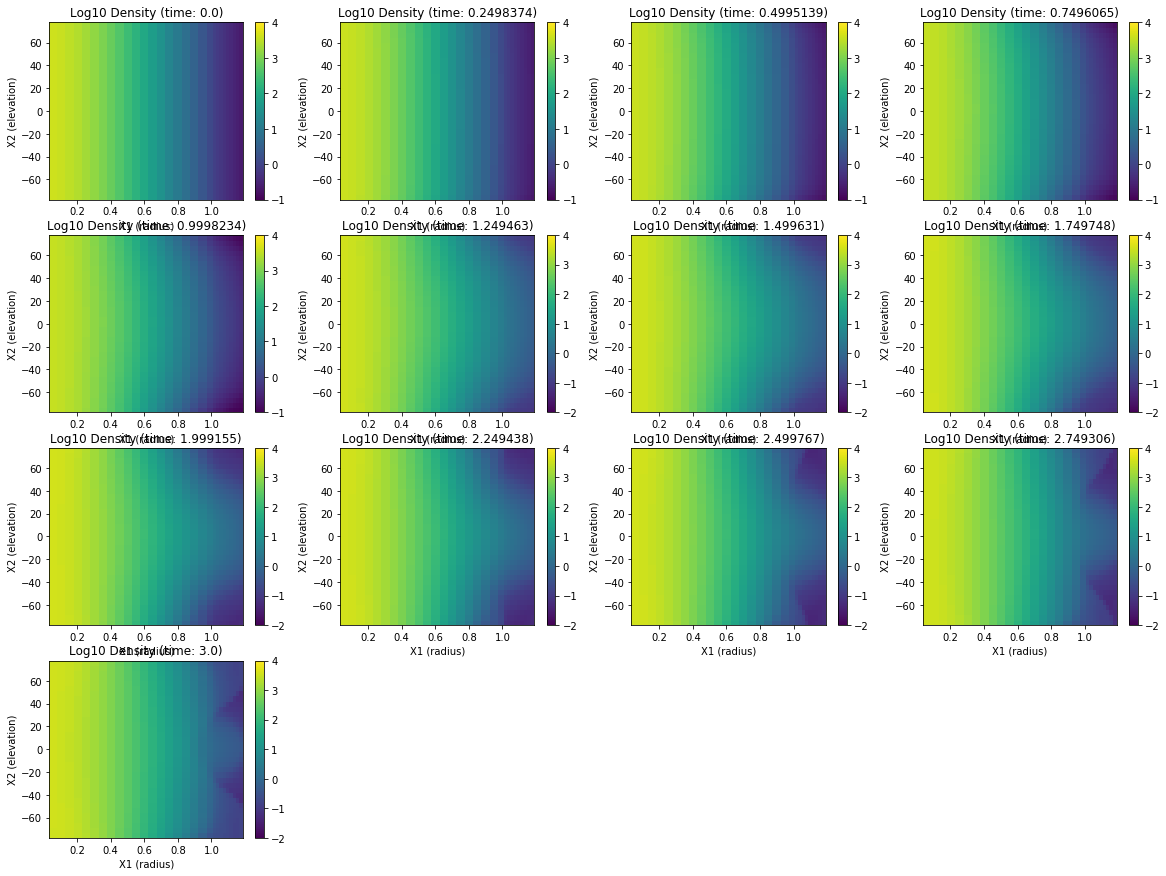

In [16]:
fig = plt.figure()

only_plot_first_frame = False # Make this False to plot for all time frames

plot_density_mesh(dh, const_azimuth=True, log=True, first_only=only_plot_first_frame)
save_plt('rho_vs_rad_vs_lat')

When we plot all the frames, we can see that the density is fairly constant with time along these 2 coordinates. Also, we observe that along a circle with fixed radius, the density is constant as the elevation is varied (i.e. in the plots above, vertical lines of density are constant).

Now we fix the elevation, and plot how the density varies with radius and azimuth. The code below will either plot this relationship for only the first time snapshot, or for all time snapshots depending on whether `only_plot_first_frame`, below, is `True` or `False`.

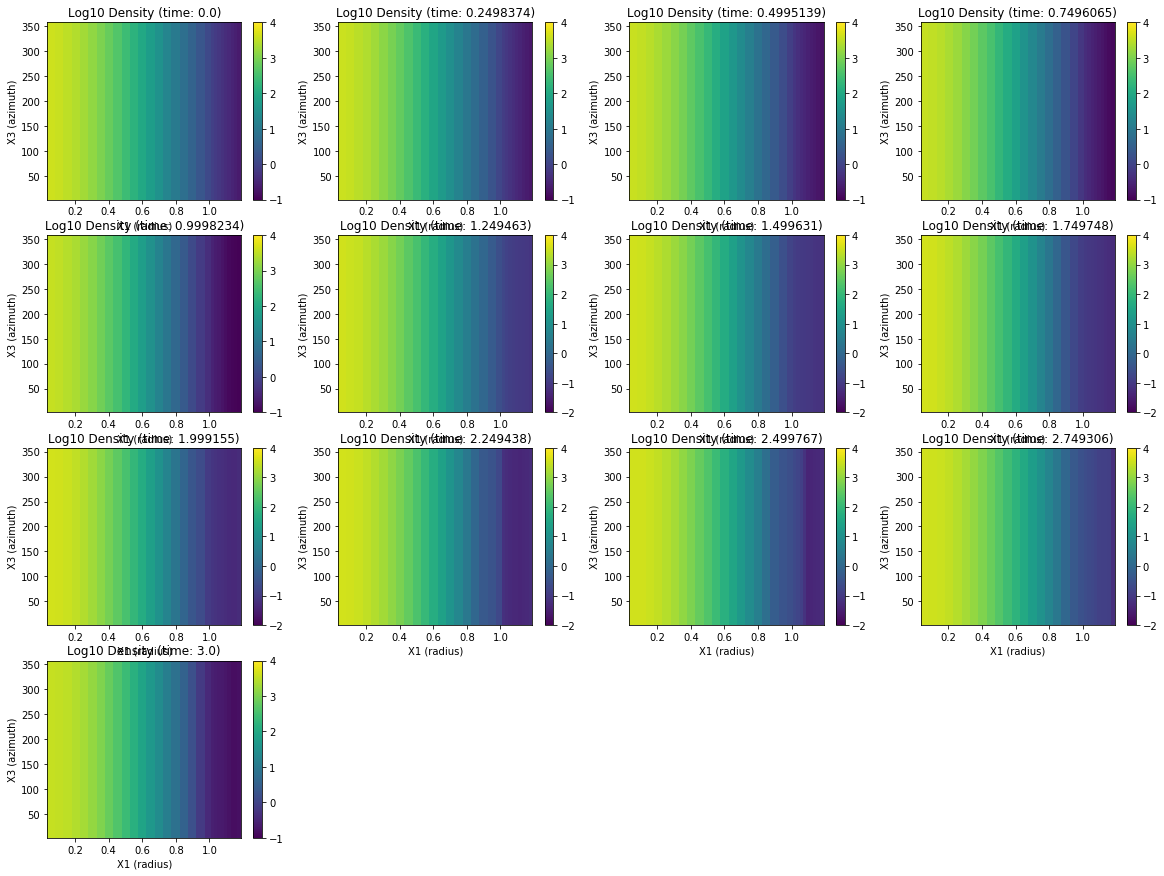

In [17]:
fig = plt.figure()

only_plot_first_frame = False # Make this False to plot for all time frames
plot_density_mesh(dh, const_elevation=True, log=True, first_only=only_plot_first_frame)
save_plt('rho_vs_rad_vs_lon')

We observe that concentric circles centred on the equatorial plane have constant density for a fixed radius. This confirms that the atmosphere is stratified.

## Radial Density Profile
Here we will plot how the density varies with radius, when the elevation and azimuth are fixed. We will define this as a general-purpose function so that we can reuse it.

In [18]:
def subplot_radius_vs_density_2d(data, theta, phi, log=False, first_only=False):
    '''
    Plots density profiles as a function of the radius for fixed theta and phi, for
    all time steps.
    
    Parameters
    ----------
    data : list of pyPLUTO.pload
        List of data frames
    theta : double
        The desired elevation angle (spherical coordinates)
    phi : double
        The desired azimuthal angle
    log : bool
        (Optional) Plots the logarithm of the density (base 10)
    first_only : bool
        (Optional) Causes only the first frame to be plotted
        
    Note that the values specified for theta and/or phi may not exist on the grid since
    it is discrete. The closest value will be used in such cases.
    '''
    
    theta_idx = (np.abs(dh[0].x2 - theta * np.pi / 180)).argmin()
    phi_idx = (np.abs(dh[0].x3 - phi * np.pi / 180)).argmin()
    
    nframes = 1 if first_only else len(data)
    nrows   = 1 if first_only else np.round(np.sqrt(nframes))
    ncols   = 1 if first_only else np.round((nframes - nrows) / 2)
    for idx in range(nframes):
        plt.subplot(nrows, ncols, idx + 1)
        qty = np.log10(dh[idx].rho[:, theta_idx, phi_idx])
        plt.scatter(dh[idx].x1, qty)
        plt.title('Time: ' + str(dh[idx].SimTime) +
                  ' (theta = ' + str(np.round(dh[idx].x2[theta_idx] * 180 / np.pi, decimals=1)) +
                  ', phi = ' + str(np.round(dh[idx].x3[phi_idx] * 180 / np.pi, decimals=1)) + ')'
        )
        plt.xlabel('X1 (radius)')
        plt.ylabel('Log 10 Density')

### North Pole

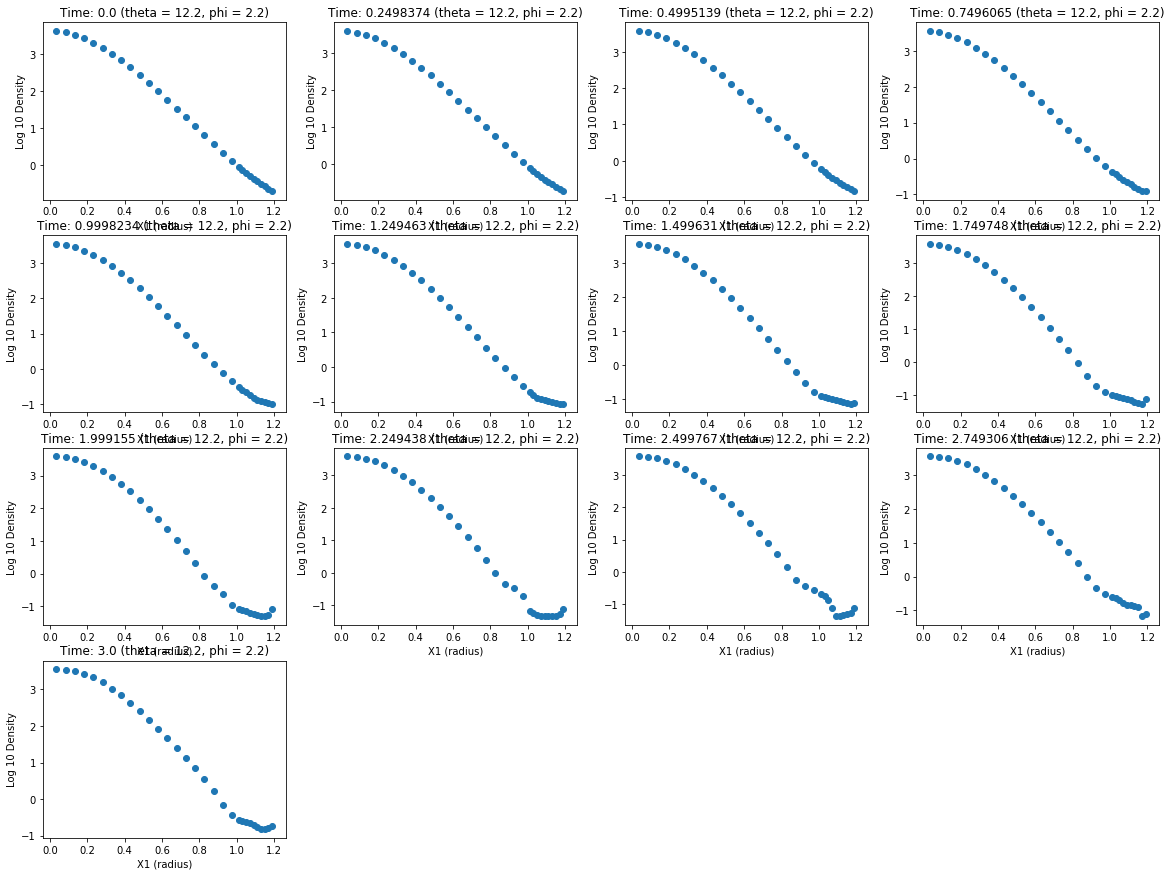

In [19]:
subplot_radius_vs_density_2d(dh, 0, 0, first_only=False);
save_plt('rho_vs_rad_north_pole_profile')

### Equator

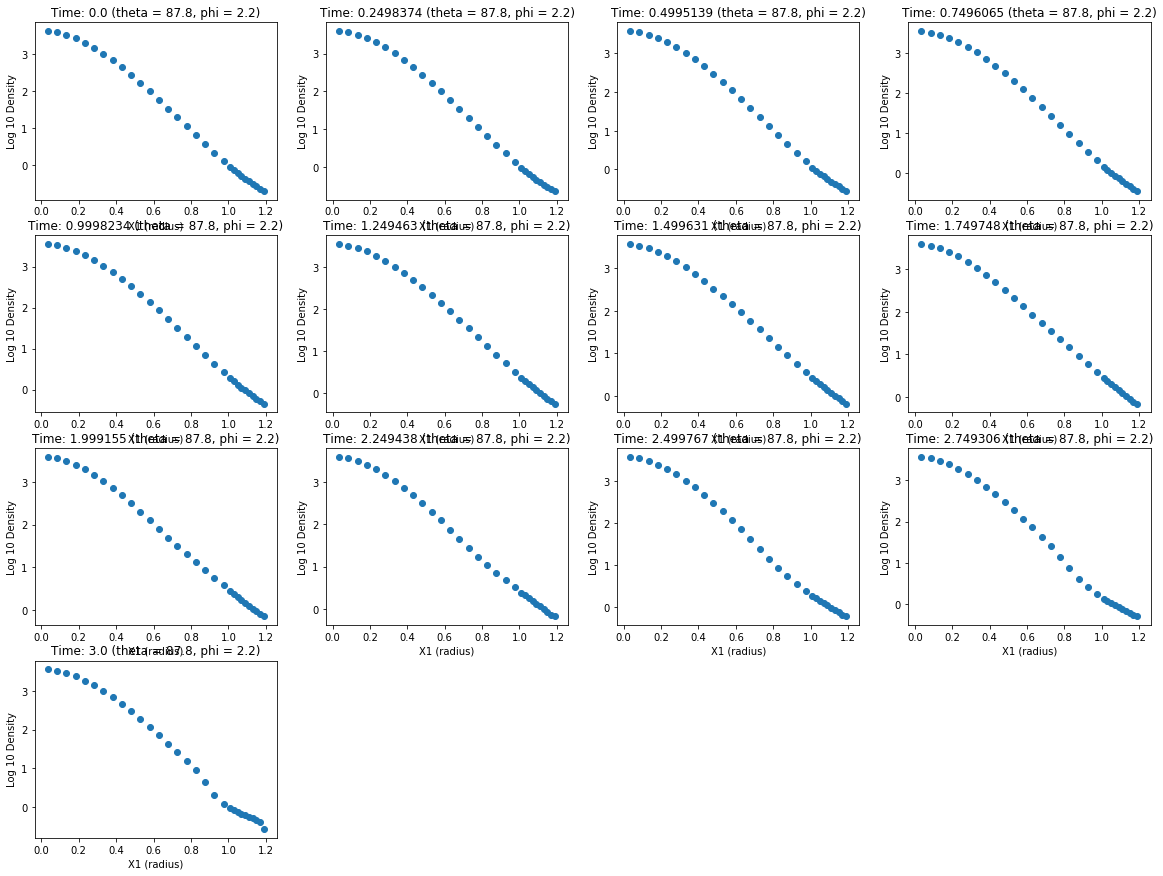

In [20]:
subplot_radius_vs_density_2d(dh, 90, 0, first_only=False);
save_plt('rho_vs_rad_equator_profile')

### South Pole

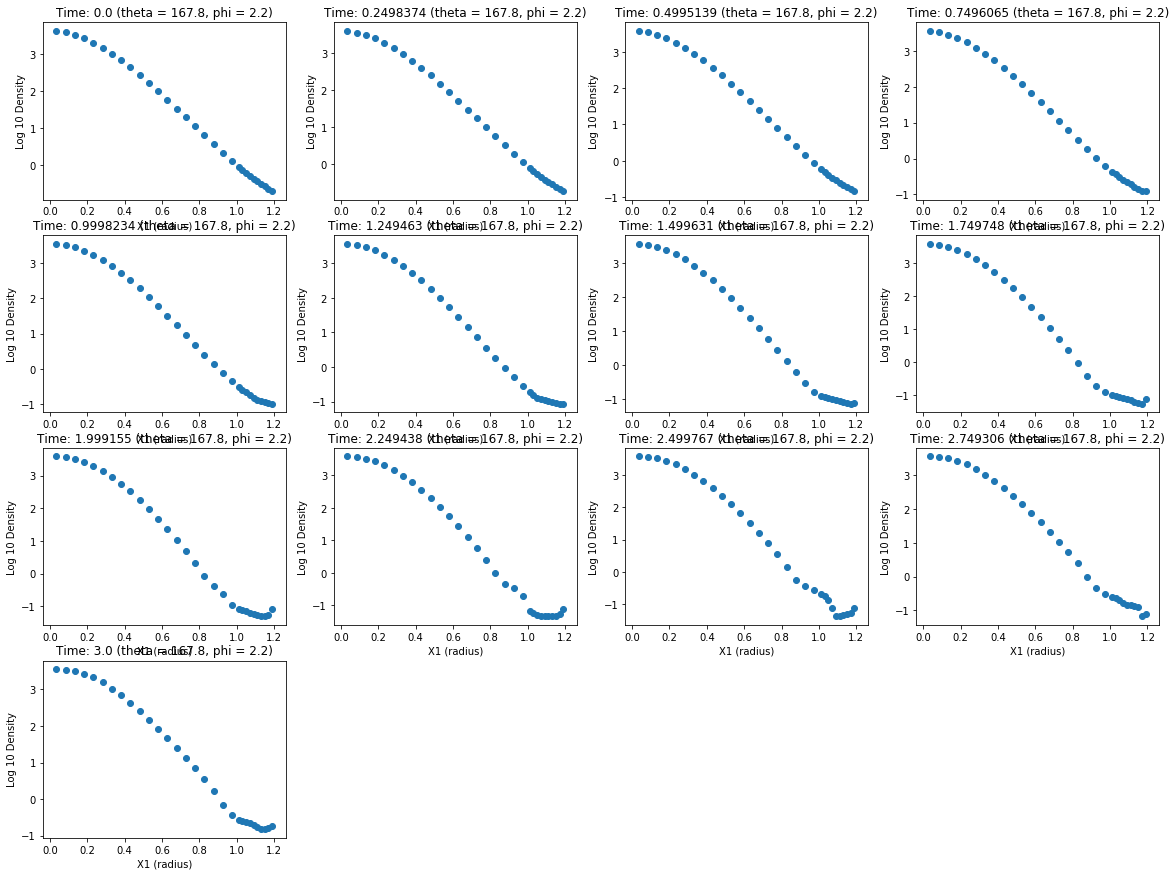

In [21]:
subplot_radius_vs_density_2d(dh, 180, 0, first_only=False);
save_plt('rho_vs_rad_south_pole_profile')

## Profile for 3 Different Alphas
$\alpha$ in pluto.ini is related to the speed of sound and thus it affects density distribution

In [ ]:
path_to_script = os.path.join(os.environ['PLUTO_DIR'], 'Work\\')
wdir = os.path.join(path_to_script, "data")

data_dirs = [directory for directory in os.listdir(os.path.join(wdir)) if "." not in directory]
print(data_dirs)
# 2: res_20u10u_36_40             <--- Alpha=10
# 3: res_20u10u_36_40_alpha31p3   <--- Alpha=31.3
# 4: res_20u10u_36_40_alpha3p13   <--- Alpha=3.13
# 5: res_26_37_40
# 6: res_26_74_80

d10   = pp.pload(0, w_dir=os.path.join(wdir, data_dirs[2] + os.sep))
d31p3 = pp.pload(0, w_dir=os.path.join(wdir, data_dirs[3] + os.sep))
d3p13 = pp.pload(0, w_dir=os.path.join(wdir, data_dirs[4] + os.sep))

theta = 90
phi = 0
theta_idx = (np.abs(d10.x2 - theta * np.pi / 180)).argmin()
phi_idx = (np.abs(d10.x3 - phi * np.pi / 180)).argmin()

fig = plt.figure(figsize=(10,10))
plt.subplot(111)

colors = ['b', 'c', 'y', 'm', 'r']

qty = np.log10(d10.rho[:, theta_idx, phi_idx])
a10 = plt.scatter(d10.x1, qty, marker='o', color=colors[0])

qty = np.log10(d31p3.rho[:, theta_idx, phi_idx])
a31p3 = plt.scatter(d31p3.x1, qty, marker='o', color=colors[1])

qty = np.log10(d3p13.rho[:, theta_idx, phi_idx])
a3p13 = plt.scatter(d3p13.x1, qty, marker='o', color=colors[2])

plt.legend((a10, a31p3, a3p13),
           ('alpha=10', 'alpha=31.3', 'alpha=3.13'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)

plt.title('Time: ' + str(d10.SimTime) +
          ' (theta = ' + str(np.round(d10.x2[theta_idx] * 180 / np.pi, decimals=1)) +
          ', phi = ' + str(np.round(d10.x3[phi_idx] * 180 / np.pi, decimals=1)) + ')'
)
plt.xlabel('X1 (radius)')
plt.ylabel('Log 10 Density')


save_plt('rho_vs_rad_equator_profile_3_alphas')

## 3D Plots
First we will define some functions to help us with plotting in 3D. The scatter plots only work nicely with cartesian coordinates so we will have to convert from spherical.

In [ ]:
def sph2cart(r, theta, phi):
    '''
    Converts the inputted spherical coordinates to cartesian coordinates
    
    Parameters
    ----------
    r : double
        The radius
    theta : double
        The altitude
    phi : double
        The azimuth
    '''
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z


def pltSphData3D(d, qty, axes, r=-1, theta=-1, phi=-1, silent=False, f=-1, log=False):
    '''
    Displays a 3D scatter plot of the specified field quantity with one of the
    coordinates held constant.
    
    Parameters
    ----------
    d : pyPLUTO.pload
        Interface to data object
    qty : str
        Name of field quantity (e.g. 'rho' or 'prs')
    axes : matplotlib.axes.SubplotBase
        Plotting interface
    r, theta, phi : int
        (Optional) Fixes a grid index for the radius, elevation, or azimuth. This
        quantity will be kept constant throughout the plot. Only one may be set at
        a time. Defaults to a plot of constant radius.
    silent : bool
        Prints info messages when True, otherwise no messages are printed
    log : bool
        (Optional) Plots the logarithm of the field quantity (base 10)
    
    Example
    -------
    # This will use the pload object `dh` to plot the density for a constant radius.
    The radius setting of 20 fixes the radius at dh.x1[20].
    pltSphData3D(dh, 'rho', r=20)
    '''
    
    # We default to a constant radius (specifically, the innermost radius)
    if r == -1 and phi == -1 and theta == -1:
        r = 0
    
    # Sanity checks on inputs
    assert(
        (r >= 0  and phi == -1 and theta == -1) or
        (r == -1 and phi >= 0  and theta == -1) or
        (r == -1 and phi == -1 and theta >= 0 )
    ), "Only one of r, phi, and theta can be specified"
    
    assert((qty == 'rho') or (qty == 'prs')), "qty must be rho or prs"
    
    # Coordinates
    #    x1 = radial
    #    x2 = latitudinal (theta)
    #    x3 = longitudinal (azimuthal, phi)
    x, y, z, c = [], [], [], []
    
    num_r = d.x1.shape[0]
    num_theta = d.x2.shape[0]
    num_phi = d.x3.shape[0]
    
    # Select either density or pressure based on the string passed in
    if qty == 'rho':
        field = d.rho
    elif qty == 'prs':
        field = d.prs
    
    # Plot the quantity
    if(r >= 0):
        assert(r <= num_r - 1), "r is too large (must be <= {0})".format(num_r - 1)
        r_l = d.x1[r]
        if not silent:
            print("Plotting sphere of radius {0}".format(r_l))
        for i in range(num_theta):
            theta_l = d.x2[i]
            for j in range(num_phi):
                phi_l = d.x3[j]
                x_p, y_p, z_p = sph2cart(r_l, theta_l, phi_l)
                x.append(x_p)
                y.append(y_p)
                z.append(z_p)
                if log:
                    c.append(np.log(field[r,i,j]))
                else:
                    c.append(field[r,i,j])
    elif(theta >= 0):
        assert(theta <= num_theta - 1), "theta is too large (must be <= {0})".format(num_theta - 1)
        theta_l = d.x2[theta]
        if not silent:
            print("Plotting cone with elevation angle {0} deg".format(theta_l * 180 / np.pi))
        for i in range(num_r):
            r_l = d.x1[i]
            for j in range(num_phi):
                phi_l = d.x3[j]
                x_p, y_p, z_p = sph2cart(r_l, theta_l, phi_l)
                x.append(x_p)
                y.append(y_p)
                z.append(z_p)
                if log:
                    c.append(np.log(field[i,theta,j]))
                else:
                    c.append(field[i,theta,j])
    else:
        assert(phi <= num_phi - 1), "phi is too large (must be <= {0})".format(num_phi - 1)
        phi_l = d.x3[phi]
        if not silent:
            print("Plotting disk with azimuth {0} deg".format(phi_l * 180 / np.pi))
        for i in range(num_r):
            r_l = d.x1[i]
            for j in range(num_theta):
                theta_l = d.x2[j]
                x_p, y_p, z_p = sph2cart(r_l, theta_l, phi_l)
                x.append(x_p)
                y.append(y_p)
                z.append(z_p)
                if log:
                    c.append(np.log(field[i,j,phi]))
                else:
                    c.append(field[i,j,phi])
    
    plt.xlabel('x')
    plt.ylabel('y')
    
    # Update the plot axes, but don't make them smaller
    axes.set_xlim3d(
        min(axes.get_xlim3d()[0], min(x)),
        max(axes.get_xlim3d()[1], max(x))
    )
    axes.set_ylim3d(
        min(axes.get_ylim3d()[0], min(y)),
        max(axes.get_ylim3d()[1], max(y))
    )
    axes.set_zlim3d(
        min(axes.get_zlim3d()[0], min(z)),
        max(axes.get_zlim3d()[1], max(z))
    )
    
    # Compute the max and min values used for the color
    if log:
        v_min = np.floor(np.min(np.log(field)))
        v_max = np.ceil(np.max(np.log(field)))
    else:
        v_min = np.floor(np.min(field))
        v_max = np.ceil(np.max(field))
    
    axes.scatter3D(x, y, z, c=c, vmin=v_min, vmax=v_max)

### Constant Radius

In [ ]:
idx = 0
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pltSphData3D(dh[idx], 'rho', ax, r=1)
pltSphData3D(dh[idx], 'rho', ax, r=19)
save_plt('3d_const_radius')

### Constant Angle of Elevation
This view demonstrates the spherical symmetry nicely

In [ ]:
idx = 0
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pltSphData3D(dh[idx], 'rho', ax, theta=5)
pltSphData3D(dh[idx], 'rho', ax, theta=10)
pltSphData3D(dh[idx], 'rho', ax, theta=19)
save_plt('3d_const_elevation')

### Constant Azimuth

In [ ]:
idx = 0
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pltSphData3D(dh[idx], 'rho', ax, phi=10)
pltSphData3D(dh[idx], 'rho', ax, phi=19)
save_plt('3d_const_azimuth')

### Combined Plots
For fun

In [ ]:
idx = 0
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pltSphData3D(dh[idx], 'rho', ax, phi=10)
pltSphData3D(dh[idx], 'rho', ax, theta=18)
save_plt('3d_azimuth_and_elevation')

In [ ]:
idx = 0
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pltSphData3D(dh[idx], 'rho', ax, theta=18)
pltSphData3D(dh[idx], 'rho', ax, r=1)
pltSphData3D(dh[idx], 'rho', ax, r=19)
save_plt('3d_radius_and_elevation')